In [2]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import listdir
import cv2
import imutils  
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from sklearn.utils import shuffle

2024-08-24 18:44:10.301738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 18:44:10.301835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 18:44:10.445565: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
image_dir="brain-mri-images-for-brain-tumor-detection/"

In [4]:
os.makedirs('augmented-images', exist_ok=True)
os.makedirs('augmented-images/yes', exist_ok=True)
os.makedirs('augmented-images/no', exist_ok=True)

In [5]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [6]:
augmented_data_path ='augmented-images/'
# augmented data for tumor
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path +'yes')
# augmented data for non-tumor
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

In [7]:
def count_images(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
                count += 1
    return count

augmented_data_path = 'augmented-images/'


tumor_path = augmented_data_path + 'yes'
tumor_count = count_images(tumor_path)
print("Number of images in tumor directory:", tumor_count)

non_tumor_path = augmented_data_path + 'no'
non_tumor_count = count_images(non_tumor_path)
print("Number of images in non-tumor directory:", non_tumor_count)

Number of images in tumor directory: 1085
Number of images in non-tumor directory: 979


In [8]:

def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


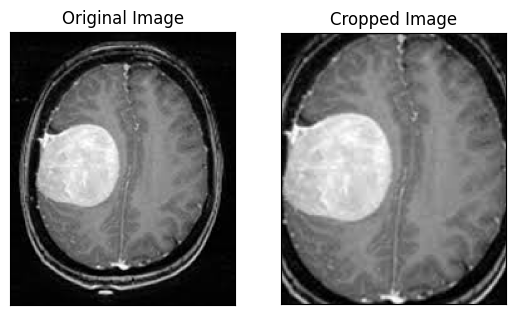

In [9]:
ex_img = cv2.imread('/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [10]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [11]:
augmented_yes = tumor_path
augmented_no = non_tumor_path

IMG_WIDTH, IMG_HEIGHT = (224, 224)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 224, 224, 3)
y shape is: (2064, 1)


In [12]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1444
number of validation examples = 310
number of test examples = 310


In [15]:
# !pip install --upgrade tensorflow
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Dropout 

In [16]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

IMG_WIDTH, IMG_HEIGHT = 224, 224 
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

# Load the InceptionV3 model 
inception_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

# Fine-tune the pre-trained model
for layer in inception_model.layers[-10:]:
    layer.trainable = True

# Create the model using Functional API
inputs = layers.Input(shape=IMG_SHAPE)
x = inception_model(inputs, training=False)  
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=x)

# Compile the model
optimizer = Adam(learning_rate=1e-5) 
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 21,770,401 (83.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20


I0000 00:00:1724525262.330761     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.8227 - loss: 0.4351 - val_accuracy: 0.6129 - val_loss: 1.1858
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9676 - loss: 0.1072 - val_accuracy: 0.5645 - val_loss: 7.9061
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.9699 - loss: 0.0985 - val_accuracy: 0.9355 - val_loss: 0.1768
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9868 - loss: 0.0508 - val_accuracy: 0.9161 - val_loss: 0.3225
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9809 - loss: 0.0461 - val_accuracy: 0.6839 - val_loss: 2.1038
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.9917 - loss: 0.0239 - val_accuracy: 0.9548 - val_loss: 0.1764
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.9153 - loss: 0.2551 - val_accuracy: 0.4839 - val_loss: 119.5800
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.8747 - loss: 0.3753 - val_accuracy: 0.5774 - val

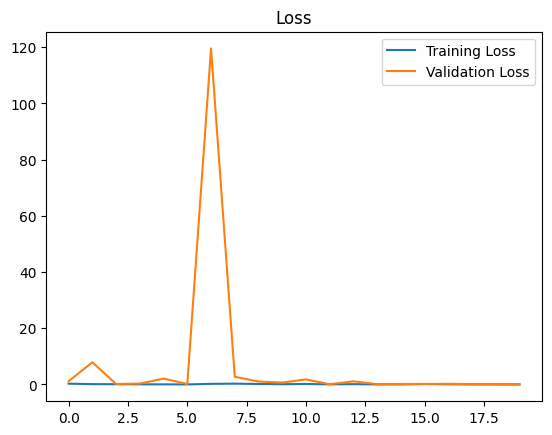

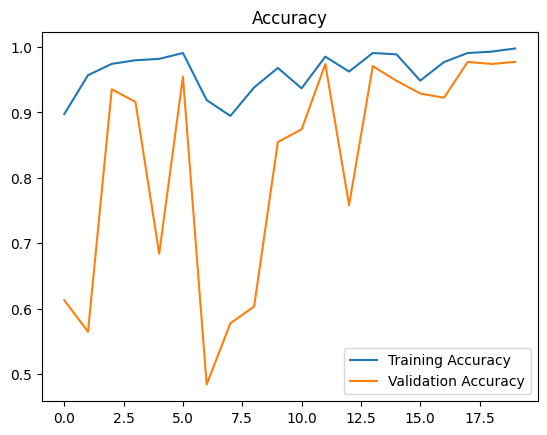

In [18]:
history = model.history.history
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    
plot_metrics(history)

In [19]:
loss, accuracy = model.evaluate(X_test, y_test)
# Print the accuracy
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test loss: {loss:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9978 - loss: 0.0147
Test Accuracy: 99.35%
Test loss: 0.03


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 673ms/step


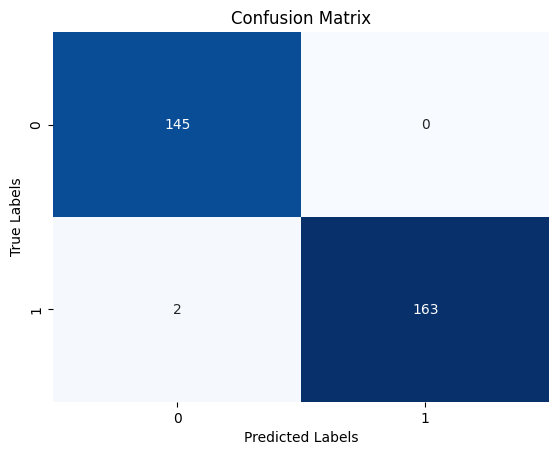

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
threshold = 0.5
y_pred_binary = (y_pred >= threshold).astype(int)

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix 
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()